# Cancer Detection

## Objective
* Build a dense prediction model by image segmentation to identify cancerous cells 
* Implement a 'virtual radiologist'. Given images of possibly cancerous tissue samples, build a detector that identifies where in the tissue cancer may reside.
* To begin reading current papers in DNN research

## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large. That means that overfitting is a real possibility.


### Implement the network topology

I'll implement the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)



In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import time 

from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)
    

In [ ]:
class ConvSteps(nn.Module): 
  """
  This class is for each step of two convolutions and ReLU's with batch normalization. 
  Calling this class results in more concise code later on. 
  Utilizes nn.Sequential to automate steps 
  """
  def __init__(self, in_channels, out_channels): 
    super(ConvSteps, self).__init__()
    self.conv_steps = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, stride = 1, kernel_size = 3, padding = 1), 
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(), 
        nn.Conv2d(out_channels, out_channels, stride = 1, kernel_size = 3, padding = 1), 
        nn.BatchNorm2d(out_channels), 
        nn.ReLU()
    )
  def forward(self, x): 
    return self.conv_steps(x) # return result from above convolutions and ReLU's 

class DownConv(nn.Module): 
  """
  This class is for each of the down-convolutions on the left hand side of the U-Net architechture. 
  I utilize nn.Sequential to maxpool and then convolve/ReLU/norm with ConvSteps class. 
  """
  def __init__(self, in_channels, out_channels): 
    super(DownConv, self).__init__()
    self.down_conv = nn.Sequential(
        nn.MaxPool2d(2, 2),  
        ConvSteps(in_channels, out_channels)
    )
  def forward(self, x): 
    return self.down_conv(x) 

class UpConv(nn.Module): 
  """
  This class is for the up-convolutions on the right side of the U-Net architecture. 
  Here I use nn.Sequential to take necessary convolutions and ReLUs and norms, but in the forward 
  method I implement the concatenations and transposes. 
  """
  def __init__(self, in_channels, out_channels): 
    super(UpConv, self).__init__()
    self.transpose = nn.ConvTranspose2d(
        in_channels, 
        out_channels, 
        stride = 2, 
        kernel_size = 2, 
        padding = 0
    )
    self.up_conv = ConvSteps(in_channels, out_channels)

  def forward(self, x, y):  
    # return un_conv on the desired concatenation  
    return self.up_conv(torch.cat((self.transpose(x), y), dim = 1)) 


In [ ]:
class CancerDetection(nn.Module):
  def __init__(self, dataset):
    super(CancerDetection, self).__init__()
    self.__dict__.update(locals())

    # define as parameters the various steps with 
    # their respective dimensions 
    self.first = ConvSteps(3, 64)
    self.down1 = DownConv(64, 128)
    self.down2 = DownConv(128, 256)
    self.down3 = DownConv(256, 512)
    self.down4 = DownConv(512, 1024)

    # here are the down convolutions with 
    # concatenations and transposed convolutions 
    self.up1 = UpConv(1024, 512)
    self.up2 = UpConv(512, 256)
    self.up3 = UpConv(256, 128)
    self.up4 = UpConv(128, 64)

    # last convolution 
    self.last = nn.Conv2d(64, 2, kernel_size = 1)

  def forward(self, input):
      
    # down convolutions 
    # each of these results in MaxPools and ConvSteps being called 
    conv0_out = self.first(input)
    conv1_out = self.down1(conv0_out)
    conv2_out = self.down2(conv1_out)
    conv3_out = self.down3(conv2_out)
    conv4_out = self.down4(conv3_out)

    # up convolutions / concatenations 
    # each results in ConvSteps and concatenations with a transpose 
    conv5_out = self.up1(conv4_out, conv3_out)
    conv6_out = self.up2(conv5_out, conv2_out)
    conv7_out = self.up3(conv6_out, conv1_out)
    conv8_out = self.up4(conv7_out, conv0_out)
    
    return self.last(conv8_out)


In [ ]:
# init datasets, dataloaders and model 
train_data = CancerDataset("tmp/cancer", train = True)
validation_data = CancerDataset("tmp/cancer", train = False)

# read in data and set up data loaders 
train_loader = DataLoader(train_data, 
                          batch_size = 4, 
                          pin_memory = True, shuffle = True)

valid_loader = DataLoader(validation_data, 
                          batch_size = 4, 
                          pin_memory = True)

# init model and call cuda 
model = CancerDetection(train_data) 
model = model.cuda()

# define objective and optimizer 
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4) 


  0%|          | 0/2750494655 [00:00<?, ?it/s]

Extracting tmp/cancer/cancer_data.tar.gz
Untarring tmp/cancer/cancer_data.tar


In [ ]:
# Your plotting code here
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
# Run your training / validation loops
start = time.time()

for epoch in range(3): 

    loop = tqdm(total = len(train_loader), position = 0, leave = False) 

    for batch, (x, y_truth) in enumerate(train_loader): 

        # x, y_truth = x.cuda(async = True), y_truth.cuda(async = True)
        x, y_truth = x.cuda(), y_truth.cuda()

        optimizer.zero_grad()
        y_hat = model(x)  
        loss = objective(y_hat, y_truth.long())
        loss.backward()

        current_time = time.time() - start 
        train_losses.append((current_time, loss.item()))

        # compute accuracy and append to list above 
        accuracy = ((torch.softmax(y_hat, 1).argmax(1) == y_truth).float()).mean()
        train_accuracy.append((current_time, accuracy)) 
        loop.set_description("epoch: {} loss: {:.4f} accuracy: {:.4}".format(epoch, loss.item(), accuracy))
        loop.update()
        optimizer.step()

        # if we are to check validation set 
        if batch % 100 == 0: 

            # compute loss, accuracy 
            val = np.mean([objective(model(x.cuda()), y.long().cuda()).item() for x, y in valid_loader])
            val_losses.append((current_time, val))

            # take accuracy, comparing to true classes and taking the mean of vector of results 
            v_accuracy = torch.mean((torch.stack([((model(x.cuda()).argmax(1) == y.cuda()).float()).mean() for x, y in valid_loader])))
            val_accuracy.append((current_time, v_accuracy))
            
    loop.close()

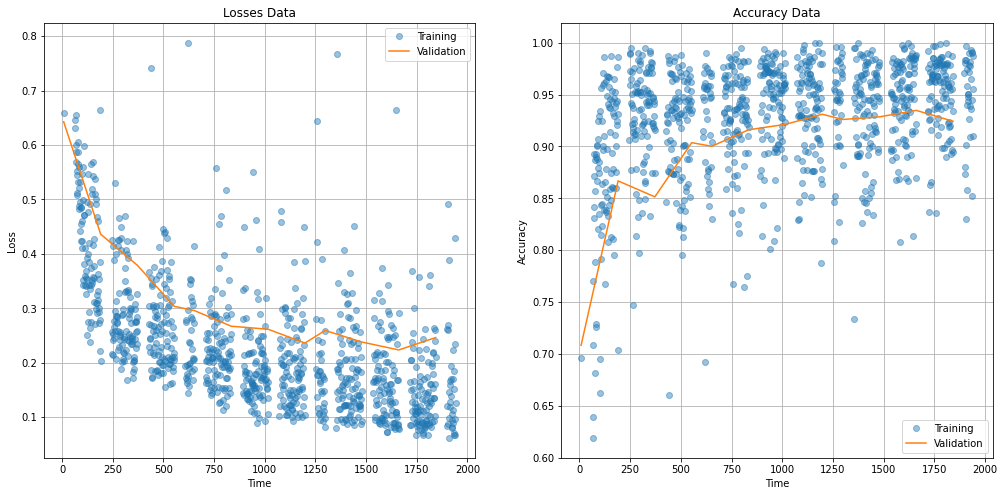

In [ ]:
plt.rcParams["figure.figsize"] = (17, 8)
# create subplots of training/validation accuracy/losses 
# adjust figure sizes too 
plt.subplot(121)
a, b = zip(*train_losses)
plt.plot(a, b, "o", alpha = 0.45, label = "Training")
a, b = zip(*val_losses)
plt.plot(a, b, label = "Validation")
plt.title("Losses Data")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(122) 
a, b = zip(*train_accuracy)
plt.plot(a, [b.item() for b in b], "o", alpha = 0.45, label = "Training")
a, b = zip(*val_accuracy)
plt.plot(a, [b.item() for b in b], label = "Validation")
plt.title("Accuracy Data")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()


plt.savefig("losses_vs_accuracy.jpg", dpi = 201)

plt.show()

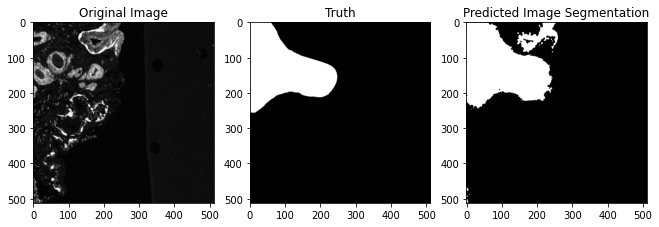

In [ ]:
# Code for testing prediction on an image
plt.rcParams["figure.figsize"] = (11, 11)

# define the needed image from the data set 
x, y_truth = validation_data[172]
x, y_truth = x.cuda(), y_truth.cuda() 

# push through the model
y_hat = model(x.unsqueeze(0).float())  

# subplots for the true image mask and the predicted one from our model 
plt.subplot(131)
plt.imshow(validation_data[172][0][0], cmap = "gray") 
plt.imshow(validation_data[172][0][1], cmap = "gray")
plt.imshow(-validation_data[172][0][2], cmap = "gray") 
plt.title("Original Image")

plt.subplot(132)
plt.imshow(validation_data[172][1], cmap = "gray")
plt.title("Truth")

plt.subplot(133)
plt.imshow(y_hat.cpu().argmax(1)[0], cmap = "gray")
plt.title("Predicted Image Segmentation")

plt.savefig("prediction_2.jpg")
plt.show()